## 10-fold CV with 3-layer CNN avg pooling

### Import and env settings

In [81]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import os

In [82]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.min_rows', 50)

### Variables/parameters used in this notebook

In [83]:
file = '../../data/home_sale_data_324_features_3_class.csv'

ckpt_path = "./ckpt/3_class_lr005/"
os.makedirs(ckpt_path, exist_ok=True)

num_classes = 3
lr = 0.005
epochs = 120

### Prepare data

In [84]:
data = pd.read_csv(file)

'''suffle rows randomly'''
data = data.sample(frac=1)

labels = data['label']

data.head()

,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,...,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA,dummy_1,dummy_2,dummy_3,label
2681,0.888889,0.785760,0.556709,0.6,0.579170,0.532258,0.957895,0.635059,0.741287,0.971015,0.75,0.933333,1.0,0.856754,1.0,1.0,1.0,0.293793,1.0,0.000000,0.166890,1.0,1.0,0.607283,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hi
14,0.555556,0.492903,0.253387,0.2,0.251426,0.236559,0.473684,0.390830,0.541894,0.637681,0.25,0.166667,0.0,0.421336,1.0,0.0,0.0,0.293793,0.0,0.400920,0.237635,0.0,0.0,0.545168,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,mid
1669,0.666667,0.523996,0.272999,0.4,0.327743,0.325269,0.973684,0.421085,0.574935,0.978261,0.50,0.966667,1.0,0.516936,1.0,1.0,0.0,0.293793,1.0,0.367342,0.325200,1.0,0.0,0.180865,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hi
986,0.777778,0.621022,0.385578,0.4,0.088659,0.284946,0.200000,0.285714,0.413321,0.072464,0.25,0.600000,0.0,0.674300,1.0,1.0,0.0,0.293793,0.0,0.000000,0.133505,0.0,0.0,0.485799,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,mid
737,0.666667,0.521422,0.272795,0.4,0.164976,0.362231,0.900000,0.420774,0.572204,0.927536,0.50,0.850000,1.0,0.516936,0.0,0.0,0.0,0.000000,1.0,0.290868,0.277398,0.0,0.0,0.272513,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,mid


In [85]:
# drop label column
data.drop(['label'], axis=1, inplace=True)
data.describe()

,OverallQual,GrLivArea,TotalSF,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,BsmtQual_Ex,Fireplaces,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,...,Neighborhood_IDOTRR,BsmtExposure_No,Neighborhood_OldTown,Foundation_BrkTil,GarageFinish_None,GarageCond_None,GarageQual_None,GarageType_None,MSSubClass_30,LotShape_Reg,PavedDrive_N,Foundation_CBlock,MSZoning_RM,HeatingQC_TA,CentralAir_N,GarageType_Detchd,MasVnrType_None,GarageFinish_Unf,BsmtQual_TA,FireplaceQu_None,KitchenQual_TA,ExterQual_TA,dummy_1,dummy_2,dummy_3
count,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,...,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.000000,2911.0,2911.0,2911.0
mean,0.565136,0.542763,0.293431,0.353143,0.200863,0.317285,0.660811,0.326706,0.487996,0.719569,0.391876,0.570892,0.447956,0.542786,0.512882,0.335967,0.087255,0.171718,0.511508,0.159954,0.203170,0.290622,0.069392,0.176542,0.245620,...,0.031261,0.652697,0.082102,0.106493,0.054277,0.054277,0.054277,0.053590,0.047750,0.637582,0.073514,0.423222,0.158708,0.293370,0.066644,0.266919,0.605634,0.421848,0.439368,0.487118,0.511852,0.616627,0.0,0.0,0.0
std,0.155988,0.125193,0.119772,0.152244,0.133043,0.143976,0.242686,0.131930,0.131369,0.219351,0.138140,0.348189,0.497369,0.128554,0.499920,0.472409,0.282257,0.181727,0.499953,0.218350,0.163524,0.454127,0.254163,0.183129,0.430528,...,0.174051,0.476195,0.274568,0.308520,0.226602,0.226602,0.226602,0.225245,0.213273,0.480781,0.261024,0.494155,0.365467,0.455385,0.249447,0.442425,0.488798,0.493939,0.496395,0.499920,0.499945,0.486292,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
25%,0.444444,0.451636,0.213557,0.200000,0.088659,0.215054,0.473684,0.247193,0.395003,0.590580,0.250000,0.250000,0.000000,0.421336,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066964,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
50%,0.555556,0.547807,0.282326,0.400000,0.164976,0.322581,0.652632,0.308172,0.481664,0.731884,0.500000,0.716667,0.000000,0.516936,1.000000,0.000000,0.000000,0.293793,1.000000,0.000000,0.179849,0.000000,0.000000,0.180865,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0
75%,0.666667,0.621247,0.356447,0.400000,0.252530,0.387097,0.905263,0.405490,0.582574,0.934783,0.500000,0.900000,1.000000,0.600315,1.000000,1.000000,0.000000,0.293793,1.000000,0.353218,0.327089,1.000000,0.000000,0.309510,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,

In [86]:
labels.unique()

array(['hi', 'mid', 'low'], dtype=object)

In [87]:
'''one-hot encode the labels'''

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
# print(list(integer_encoded))

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
labels = onehot_encoder.fit_transform(integer_encoded)

print('Number of classes: ', len(labels[0]))
print(labels)

Number of classes:  3
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [88]:
data_np = data.to_numpy()
data_np.shape
data_np = data_np.reshape(len(data), 18, 18)
data_np.shape

(2911, 18, 18)

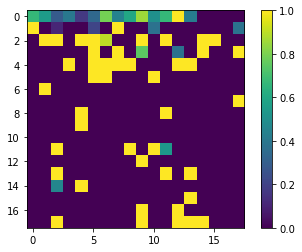

In [89]:
# data_np[0].shape

nArray = np.array(data_np[99])


a11=nArray.reshape(18,18)
plt.imshow(a11)
plt.colorbar()
plt.show()

In [90]:
labels.shape

(2911, 3)

In [91]:
all_examples = data_np
all_examples.shape

(2911, 18, 18)

#### train test splitting
- hold out 15% for testing
- use 85% to train model with K-fold CV

In [92]:
ttl_samples = all_examples.shape[0] 
test_ratio = 0.15
test_samples = int(test_ratio * all_examples.shape[0])

train_examples = all_examples[:-1*test_samples]
test_examples = all_examples[-1*test_samples:]

train_labels = labels[:-1*test_samples]
test_labels = labels[-1*test_samples:]


In [93]:
print('train: ', train_examples.shape)
print('test: ', test_examples.shape)
print('train label: ', train_labels.shape)
print('test label: ', test_labels.shape)

train:  (2475, 18, 18)
test:  (436, 18, 18)
train label:  (2475, 3)
test label:  (436, 3)


In [94]:
# trainX = train_examples.reshape(ttl_samples-test_samples, 18,18,1)
# trainY = train_labels

# testX = test_examples.reshape(test_samples, 18,18,1)
# testY = test_labels


### Prepare model

In [95]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')


def create_model(num_classes=5, lr=0.005):

	# Working
	with tf.device('/cpu:0'):
		data_augmentation = tf.keras.Sequential([ 
			tf.keras.layers.RandomFlip("horizontal", input_shape=(18, 18, 1)),
	  		tf.keras.layers.RandomRotation(0.1),
		    tf.keras.layers.RandomZoom(0.1)
			])


	model = tf.keras.Sequential([
		# data_augmentation,
	  	# tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(18, 18, 1)),
		tf.keras.layers.AveragePooling2D((2, 2)),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.AveragePooling2D((2,2)),
		tf.keras.layers.Dropout(0.1),
	  	tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
	  	tf.keras.layers.AveragePooling2D(),
		tf.keras.layers.Dropout(0.1),
		tf.keras.layers.Flatten(),
		tf.keras.layers.Dense(128, activation='relu'),
		tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
	])

	# opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
	opt = tf.keras.optimizers.Adam(lr=lr)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return model


Num GPUs Available:  1


In [54]:
model = create_model()
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 18, 18, 16)        160       
                                                                 
 average_pooling2d_51 (Avera  (None, 9, 9, 16)         0         
 gePooling2D)                                                    
                                                                 
 dropout_51 (Dropout)        (None, 9, 9, 16)          0         
                                                                 
 conv2d_52 (Conv2D)          (None, 9, 9, 32)          4640      
                                                                 
 average_pooling2d_52 (Avera  (None, 4, 4, 32)         0         
 gePooling2D)                                                    
                                                                 
 dropout_52 (Dropout)        (None, 4, 4, 32)        

/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Training

In [55]:
from sklearn.model_selection import KFold

# modify to save ckpt for each test
ckpt = os.path.join(ckpt_path, "val_acc_{val_accuracy:.3f}.hdf5")

# training params
epochs = epochs
num_classes = num_classes
lr = lr

# the k for k fold CV
n_split = 10

# for recording best performance
max_acc = 0
best_history = None

'''
k-fold cross validation
Save the best model using validation accuracy as metric
Print the global best performace when finished
'''
for train_index, test_index in KFold(n_split).split(train_examples):

    x_train, x_vad = train_examples[train_index], train_examples[test_index]
    y_train, y_vad = train_labels[train_index], train_labels[test_index]

    model=create_model(num_classes, lr)
  
    # callbacks
    checkpoint_filepath = ckpt
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )

    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        mode='auto',
    )

    # Model weights are saved at the end of every epoch, if it's the best seen so far.
    history = model.fit(x_train, y_train, epochs=epochs, validation_data=(x_vad, y_vad),
                        callbacks=[model_checkpoint_callback, early_stopping_callback])

    val_acc = max(history.history['val_accuracy'])
    
    if val_acc > max_acc:
        max_acc = val_acc
        best_history = history
        # print('Best acc so far. Saving params...\n')

print('Finish {}-fold cross validation'.format(n_split))
print('Best performing model has {:.4f} validation accuracy'.format(max_acc))

#CPU
# with tf.device('/CPU:0'):
#     history = model.fit(trainX, trainY, epochs=epochs,validation_data=(testX, testY), batch_size=64)

# deafult go with GPU
# history = model.fit(trainX, trainY, epochs=epochs,validation_data=(testX, testY), batch_size=64)

Epoch 1/120


2022-05-09 00:07:54.886371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 2.0115 - accuracy: 0.2075
Epoch 1: val_accuracy improved from -inf to 0.28226, saving model to ./ckpt/10_class_lr005/val_acc_0.282.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 2.0115 - accuracy: 0.2075 - val_loss: 1.7194 - val_accuracy: 0.2823
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.8748 - accuracy: 0.1875

2022-05-09 00:07:56.032850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


67/70 [===========================>..] - ETA: 0s - loss: 1.6924 - accuracy: 0.3050
Epoch 2: val_accuracy improved from 0.28226 to 0.34274, saving model to ./ckpt/10_class_lr005/val_acc_0.343.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.6933 - accuracy: 0.3026 - val_loss: 1.6846 - val_accuracy: 0.3427
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 1.6209 - accuracy: 0.3274
Epoch 3: val_accuracy improved from 0.34274 to 0.38306, saving model to ./ckpt/10_class_lr005/val_acc_0.383.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.6223 - accuracy: 0.3273 - val_loss: 1.5456 - val_accuracy: 0.3831
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 1.5429 - accuracy: 0.3458
Epoch 4: val_accuracy improved from 0.38306 to 0.39919, saving model to ./ckpt/10_class_lr005/val_acc_0.399.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 1.5429 - accuracy: 0.3458 - val_loss: 1.4750 - val_accuracy: 0.399

2022-05-09 00:08:36.828083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.9626 - accuracy: 0.2259
Epoch 1: val_accuracy improved from -inf to 0.31855, saving model to ./ckpt/10_class_lr005/val_acc_0.319.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 1.9626 - accuracy: 0.2259 - val_loss: 1.6893 - val_accuracy: 0.3185
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 1.5037 - accuracy: 0.4375

2022-05-09 00:08:37.982081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.6669 - accuracy: 0.3094
Epoch 2: val_accuracy did not improve from 0.31855
70/70 [==============================] - 1s 12ms/step - loss: 1.6669 - accuracy: 0.3094 - val_loss: 1.6301 - val_accuracy: 0.3145
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 1.6248 - accuracy: 0.3401
Epoch 3: val_accuracy improved from 0.31855 to 0.36290, saving model to ./ckpt/10_class_lr005/val_acc_0.363.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.6218 - accuracy: 0.3417 - val_loss: 1.5621 - val_accuracy: 0.3629
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 1.5325 - accuracy: 0.3591
Epoch 4: val_accuracy did not improve from 0.36290
70/70 [==============================] - 1s 12ms/step - loss: 1.5332 - accuracy: 0.3597 - val_loss: 1.5075 - val_accuracy: 0.3548
Epoch 5/120
69/70 [============================>.] - ETA: 0s - loss: 1.4850 - accuracy: 0.3646
Epoch 5: val_accuracy impro

2022-05-09 00:09:19.342843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 2.0122 - accuracy: 0.1989
Epoch 1: val_accuracy improved from -inf to 0.25806, saving model to ./ckpt/10_class_lr005/val_acc_0.258.hdf5
70/70 [==============================] - 2s 14ms/step - loss: 2.0122 - accuracy: 0.1989 - val_loss: 1.7833 - val_accuracy: 0.2581
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.5498 - accuracy: 0.3750

2022-05-09 00:09:20.355946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 1.6703 - accuracy: 0.3125
Epoch 2: val_accuracy improved from 0.25806 to 0.33871, saving model to ./ckpt/10_class_lr005/val_acc_0.339.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 1.6716 - accuracy: 0.3089 - val_loss: 1.6272 - val_accuracy: 0.3387
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 1.6000 - accuracy: 0.3545
Epoch 3: val_accuracy did not improve from 0.33871
70/70 [==============================] - 1s 14ms/step - loss: 1.5975 - accuracy: 0.3561 - val_loss: 1.5432 - val_accuracy: 0.3387
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 1.5493 - accuracy: 0.3689
Epoch 4: val_accuracy did not improve from 0.33871
70/70 [==============================] - 1s 13ms/step - loss: 1.5491 - accuracy: 0.3678 - val_loss: 1.5877 - val_accuracy: 0.3185
Epoch 5/120
69/70 [============================>.] - ETA: 0s - loss: 1.4765 - accuracy: 0.3804
Epoch 5: val_accuracy impro

2022-05-09 00:09:44.332267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 2.0054 - accuracy: 0.2137
Epoch 1: val_accuracy improved from -inf to 0.28629, saving model to ./ckpt/10_class_lr005/val_acc_0.286.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 2.0054 - accuracy: 0.2137 - val_loss: 1.6757 - val_accuracy: 0.2863
Epoch 2/120
 1/70 [..............................] - ETA: 1s - loss: 1.6730 - accuracy: 0.2500

2022-05-09 00:09:45.428802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.6703 - accuracy: 0.3247
Epoch 2: val_accuracy improved from 0.28629 to 0.34677, saving model to ./ckpt/10_class_lr005/val_acc_0.347.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.6703 - accuracy: 0.3247 - val_loss: 1.5876 - val_accuracy: 0.3468
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 1.5665 - accuracy: 0.3510
Epoch 3: val_accuracy improved from 0.34677 to 0.39516, saving model to ./ckpt/10_class_lr005/val_acc_0.395.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 1.5670 - accuracy: 0.3511 - val_loss: 1.4532 - val_accuracy: 0.3952
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 1.4817 - accuracy: 0.3806
Epoch 4: val_accuracy improved from 0.39516 to 0.43952, saving model to ./ckpt/10_class_lr005/val_acc_0.440.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 1.4782 - accuracy: 0.3844 - val_loss: 1.3529 - val_accuracy: 0.439

2022-05-09 00:10:19.309681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.9285 - accuracy: 0.2506
Epoch 1: val_accuracy improved from -inf to 0.31855, saving model to ./ckpt/10_class_lr005/val_acc_0.319.hdf5
70/70 [==============================] - 2s 16ms/step - loss: 1.9285 - accuracy: 0.2506 - val_loss: 1.6903 - val_accuracy: 0.3185
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.7447 - accuracy: 0.3438

2022-05-09 00:10:20.445957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.6568 - accuracy: 0.3107
Epoch 2: val_accuracy improved from 0.31855 to 0.35887, saving model to ./ckpt/10_class_lr005/val_acc_0.359.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 1.6568 - accuracy: 0.3107 - val_loss: 1.6300 - val_accuracy: 0.3589
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 1.5704 - accuracy: 0.3538
Epoch 3: val_accuracy improved from 0.35887 to 0.36290, saving model to ./ckpt/10_class_lr005/val_acc_0.363.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.5704 - accuracy: 0.3538 - val_loss: 1.5105 - val_accuracy: 0.3629
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 1.5227 - accuracy: 0.3542
Epoch 4: val_accuracy improved from 0.36290 to 0.38710, saving model to ./ckpt/10_class_lr005/val_acc_0.387.hdf5
70/70 [==============================] - 1s 17ms/step - loss: 1.5215 - accuracy: 0.3547 - val_loss: 1.4490 - val_accuracy: 0.387

2022-05-09 00:10:40.998094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.9921 - accuracy: 0.2020
Epoch 1: val_accuracy improved from -inf to 0.31579, saving model to ./ckpt/10_class_lr005/val_acc_0.316.hdf5
70/70 [==============================] - 2s 21ms/step - loss: 1.9921 - accuracy: 0.2020 - val_loss: 1.7034 - val_accuracy: 0.3158
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.7634 - accuracy: 0.2188

2022-05-09 00:10:42.472285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


66/70 [===========================>..] - ETA: 0s - loss: 1.6879 - accuracy: 0.3040
Epoch 2: val_accuracy improved from 0.31579 to 0.37652, saving model to ./ckpt/10_class_lr005/val_acc_0.377.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 1.6815 - accuracy: 0.3083 - val_loss: 1.5974 - val_accuracy: 0.3765
Epoch 3/120
66/70 [===========================>..] - ETA: 0s - loss: 1.6033 - accuracy: 0.3357
Epoch 3: val_accuracy improved from 0.37652 to 0.39676, saving model to ./ckpt/10_class_lr005/val_acc_0.397.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.5979 - accuracy: 0.3357 - val_loss: 1.5099 - val_accuracy: 0.3968
Epoch 4/120
70/70 [==============================] - ETA: 0s - loss: 1.4696 - accuracy: 0.3797
Epoch 4: val_accuracy did not improve from 0.39676
70/70 [==============================] - 1s 13ms/step - loss: 1.4696 - accuracy: 0.3797 - val_loss: 1.4182 - val_accuracy: 0.3968
Epoch 5/120
70/70 [==============================] - ETA: 0s

2022-05-09 00:11:03.103805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.9894 - accuracy: 0.2105
Epoch 1: val_accuracy improved from -inf to 0.31984, saving model to ./ckpt/10_class_lr005/val_acc_0.320.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 1.9894 - accuracy: 0.2105 - val_loss: 1.6220 - val_accuracy: 0.3198
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.9848 - accuracy: 0.3125

2022-05-09 00:11:04.231966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.7053 - accuracy: 0.3070
Epoch 2: val_accuracy improved from 0.31984 to 0.34413, saving model to ./ckpt/10_class_lr005/val_acc_0.344.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 1.7053 - accuracy: 0.3070 - val_loss: 1.6511 - val_accuracy: 0.3441
Epoch 3/120
68/70 [============================>.] - ETA: 0s - loss: 1.6339 - accuracy: 0.3171
Epoch 3: val_accuracy improved from 0.34413 to 0.35628, saving model to ./ckpt/10_class_lr005/val_acc_0.356.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.6315 - accuracy: 0.3160 - val_loss: 1.5448 - val_accuracy: 0.3563
Epoch 4/120
68/70 [============================>.] - ETA: 0s - loss: 1.5523 - accuracy: 0.3529
Epoch 4: val_accuracy did not improve from 0.35628
70/70 [==============================] - 1s 14ms/step - loss: 1.5496 - accuracy: 0.3546 - val_loss: 1.4546 - val_accuracy: 0.3441
Epoch 5/120
66/70 [===========================>..] - ETA: 0s

2022-05-09 00:11:35.362852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.9021 - accuracy: 0.2576
Epoch 1: val_accuracy improved from -inf to 0.27530, saving model to ./ckpt/10_class_lr005/val_acc_0.275.hdf5
70/70 [==============================] - 2s 17ms/step - loss: 1.9021 - accuracy: 0.2576 - val_loss: 1.6854 - val_accuracy: 0.2753
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.6714 - accuracy: 0.2812

2022-05-09 00:11:36.591761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


69/70 [============================>.] - ETA: 0s - loss: 1.6605 - accuracy: 0.3161
Epoch 2: val_accuracy did not improve from 0.27530
70/70 [==============================] - 1s 13ms/step - loss: 1.6620 - accuracy: 0.3151 - val_loss: 1.7536 - val_accuracy: 0.2591
Epoch 3/120
70/70 [==============================] - ETA: 0s - loss: 1.5746 - accuracy: 0.3465
Epoch 3: val_accuracy improved from 0.27530 to 0.38866, saving model to ./ckpt/10_class_lr005/val_acc_0.389.hdf5
70/70 [==============================] - 1s 15ms/step - loss: 1.5746 - accuracy: 0.3465 - val_loss: 1.5443 - val_accuracy: 0.3887
Epoch 4/120
69/70 [============================>.] - ETA: 0s - loss: 1.4961 - accuracy: 0.3650
Epoch 4: val_accuracy improved from 0.38866 to 0.39676, saving model to ./ckpt/10_class_lr005/val_acc_0.397.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.4963 - accuracy: 0.3658 - val_loss: 1.4853 - val_accuracy: 0.3968
Epoch 5/120
70/70 [==============================] - ETA: 0s

2022-05-09 00:12:06.456719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.8966 - accuracy: 0.2451

2022-05-09 00:12:07.751913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.32389, saving model to ./ckpt/10_class_lr005/val_acc_0.324.hdf5
70/70 [==============================] - 2s 20ms/step - loss: 1.8966 - accuracy: 0.2451 - val_loss: 1.6358 - val_accuracy: 0.3239
Epoch 2/120
69/70 [============================>.] - ETA: 0s - loss: 1.6720 - accuracy: 0.3111
Epoch 2: val_accuracy improved from 0.32389 to 0.35223, saving model to ./ckpt/10_class_lr005/val_acc_0.352.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 1.6707 - accuracy: 0.3119 - val_loss: 1.5729 - val_accuracy: 0.3522
Epoch 3/120
67/70 [===========================>..] - ETA: 0s - loss: 1.5700 - accuracy: 0.3535
Epoch 3: val_accuracy improved from 0.35223 to 0.36032, saving model to ./ckpt/10_class_lr005/val_acc_0.360.hdf5
70/70 [==============================] - 1s 14ms/step - loss: 1.5749 - accuracy: 0.3523 - val_loss: 1.5454 - val_accuracy: 0.3603
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 1.4863 - accur

2022-05-09 00:12:46.834573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


70/70 [==============================] - ETA: 0s - loss: 1.9547 - accuracy: 0.2217
Epoch 1: val_accuracy improved from -inf to 0.27530, saving model to ./ckpt/10_class_lr005/val_acc_0.275.hdf5
70/70 [==============================] - 2s 15ms/step - loss: 1.9547 - accuracy: 0.2217 - val_loss: 1.7431 - val_accuracy: 0.2753
Epoch 2/120
 1/70 [..............................] - ETA: 0s - loss: 1.5955 - accuracy: 0.2812

2022-05-09 00:12:47.908484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


68/70 [============================>.] - ETA: 0s - loss: 1.6303 - accuracy: 0.3323
Epoch 2: val_accuracy improved from 0.27530 to 0.35223, saving model to ./ckpt/10_class_lr005/val_acc_0.352.hdf5
70/70 [==============================] - 1s 12ms/step - loss: 1.6314 - accuracy: 0.3317 - val_loss: 1.5952 - val_accuracy: 0.3522
Epoch 3/120
69/70 [============================>.] - ETA: 0s - loss: 1.5561 - accuracy: 0.3537
Epoch 3: val_accuracy improved from 0.35223 to 0.40891, saving model to ./ckpt/10_class_lr005/val_acc_0.409.hdf5
70/70 [==============================] - 1s 13ms/step - loss: 1.5557 - accuracy: 0.3546 - val_loss: 1.4523 - val_accuracy: 0.4089
Epoch 4/120
67/70 [===========================>..] - ETA: 0s - loss: 1.4685 - accuracy: 0.3825
Epoch 4: val_accuracy improved from 0.40891 to 0.48178, saving model to ./ckpt/10_class_lr005/val_acc_0.482.hdf5
70/70 [==============================] - 1s 16ms/step - loss: 1.4690 - accuracy: 0.3793 - val_loss: 1.3567 - val_accuracy: 0.481

### Visualize training result

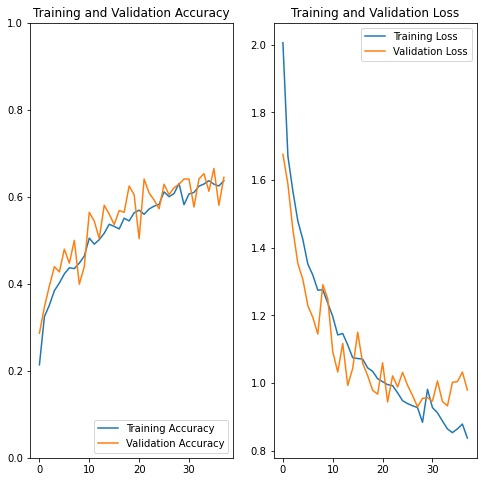

In [56]:
from matplotlib import pyplot as plt

history = best_history

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# because of early stopping, can't just use "epochs"
epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate on test data

In [96]:
model = create_model(num_classes=num_classes)
model.load_weights(os.path.join(ckpt_path, "val_acc_0.883.hdf5"))

loss, acc = model.evaluate(test_examples, test_labels)

print('\nevaluate on test set:\nloss = {:.5f}\tacc = {:.3f}%'.format(loss, acc*100))

/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-05-09 00:17:29.676630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 12ms/step - loss: 0.2967 - accuracy: 0.8899

evaluate on test set:
loss = 0.29670	acc = 88.991%


In [151]:
%reset -f